# Logistic Regression 


<img src="https://qph.fs.quoracdn.net/main-qimg-7c9b7670c90b286160a88cb599d1b733" style="height:250px">
<h3><center>Logistic Regression</center></h3>

# 1) Packages 

Let's first import all of the packages we need for this assignment. 

- [tensorflow](https://www.tensorflow.org/) is what we will use to build our neural networks 

- [matplotlib](https://matplotlib.org/) helps to plot data and visualize the data

- [numpy](https://numpy.org/) helps us make our training and test set arrays

- [keras](https://keras.io/) helps us to make our neural networks 

- [pytube](https://python-pytube.readthedocs.io/en/latest/) helps us download video content and transform to images

- [sklearn](https://scikit-learn.org/stable/index.html) helps us use the logistic regression function

- [math](https://docs.python.org/2/library/math.html) helps us find min, max, floor, etc




In [24]:
#Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras

#Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
import cv2
from pytube import YouTube
import math
import sklearn

# Import Data 

In [25]:
power_puff_video = YouTube('https://www.youtube.com/watch?v=1mZXmnkTYOM')
bob_the_builder_video = YouTube('https://www.youtube.com/watch?v=lTPX8gc192I')


#Look for the valid video format
puff_stream = power_puff_video.streams.filter(file_extension = "mp4").all()
builder_stream = bob_the_builder_video.streams.filter(file_extension = "mp4").all()

#Download the videos 
power_puff_video_mp4 = power_puff_video.streams.get_by_itag(18).download()
bob_the_builder_video_mp4 = bob_the_builder_video.streams.get_by_itag(18).download()

    


# Create the class names array

In [26]:
class_names = ['Bob the Builder', 'Power Puff Girls']

# Cut the video frames and assign to directory 


In [27]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random

# create directories
dataset_home = 'Downloads/PowerPuff_versus_BobBuilder/'
src_directory = 'Downloads/PowerPuff_BobBuilder_Src/'
makedirs(src_directory, exist_ok = True)

subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['PowerPuff/', 'BobBuilder/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)

In [28]:

def cut_Frames(video_name, video_class, dst, n_images, skip_seconds):
    videocap = cv2.VideoCapture(video_name)
    totalNumFrames = int(videocap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(videocap.get(cv2.CAP_PROP_FPS))
    every_xth_frame = math.floor((totalNumFrames - skip_seconds * fps) / n_images) - 1
    
    
    
    success, img = videocap.read()
    framecount = 0
    img_count = 0 
    
    
    while success: 
    
        success, img = videocap.read()
        
        if every_xth_frame == 0 :
            print("pick a different number of total frames or frames to skip")
            break
        
        if(framecount > skip_seconds*30):
            
            if not success:
                break
                
        if (framecount % every_xth_frame == 0):
            cv2.imwrite(dst + video_class + str(img_count) + ".jpg", img)
            img_count += 1
            
            
        if (round(img_count / n_images, 2) * 100 % 10 == 0): 

                    print("Completed:", round(img_count / n_images, 2), "done.", end="\r")



        if img_count == n_images:

            break   

            

        framecount += 1

        
def assignTrainTest(source_directory, dataset_home): 
    # seed random number generator
    seed(1)
    # define ratio of pictures to use for validation
    val_ratio = 0.25
    # copy training dataset images into subdirectories
  
    for file in listdir(source_directory):
        src = source_directory + '/' + file

        dst_dir = 'train/'
        if random() < val_ratio:
            dst_dir = 'test/'
        if file.startswith('PowerPuff'):
            dst = dataset_home + dst_dir + 'PowerPuff/'  + file
            copyfile(src, dst)
        elif file.startswith('BobBuilder'):
            dst = dataset_home + dst_dir + 'BobBuilder/'  + file
            copyfile(src, dst)

            

In [29]:
cut_Frames(bob_the_builder_video_mp4, 'BobBuilder' , src_directory, 1000, 2)
cut_Frames(power_puff_video_mp4, 'PowerPuff', src_directory, 1000, 2)

assignTrainTest(src_directory, dataset_home)


# Create iterative directory 

In [30]:
from keras.preprocessing.image import ImageDataGenerator




datagen = ImageDataGenerator(rescale= 1./255)

#training directory iterator
train_it = datagen.flow_from_directory(dataset_home + 'train/',
	class_mode='binary', batch_size = 1518 , target_size=(200, 200), shuffle = True)



#testing directory iterator
test_it = datagen.flow_from_directory(dataset_home + 'test/' , 
	class_mode='binary', batch_size= 482, target_size=(200, 200), shuffle =  True)


#Convert to arrays
x, y = train_it.next()
X, Y = test_it.next()





Found 1518 images belonging to 2 classes.
Found 482 images belonging to 2 classes.


# Let's look at some sample frames 

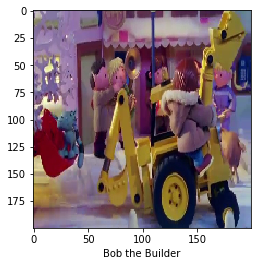

In [31]:
plt.figure()
plt.imshow(x[1345])
plt.grid(False)
plt.xlabel(class_names[int(y[1345])])
plt.show()


# 6) Convert to 2D color scale and flatten

## Convert to 1 color bin
Now, parse through the arrays and convert the 3 bins used for colors to 1 bin. 

## Flatten the image
Flatten the image such that it becomes a 1D array

In [32]:
train_photos = list()
test_photos = list()



#Train data conversion

for i in range (len(y)):
    
    photo = cv2.cvtColor(x[i], cv2.COLOR_BGR2GRAY)
    #flatten 
    flat = photo.reshape(-1)
    #Add to new list
    train_photos.append(flat)
    
#Test data conversion
    
for i in range(len(Y)):
    photo = cv2.cvtColor(X[i], cv2.COLOR_BGR2GRAY)
    #flatten 
    flat = photo.reshape(-1)
    #Add to new list
    test_photos.append(flat)


    
#Convert lists to arrays 

test_photos = np.asarray(test_photos, dtype=np.float32)
train_photos = np.asarray(train_photos, dtype=np.float32)

train_labels = y

test_labels = Y



# Define Model

In [33]:
from sklearn.linear_model import LogisticRegression


# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()






# Train Models 


In [34]:
logisticRegr.fit(train_photos , train_labels)



C:\Users\coder\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

# Test Logistic Model

In [35]:
logistic_predictions = logisticRegr.predict(test_photos)
logistic_score = logisticRegr.score(test_photos, test_labels)
print(logistic_score)

1.0


# Confusion Matrix 

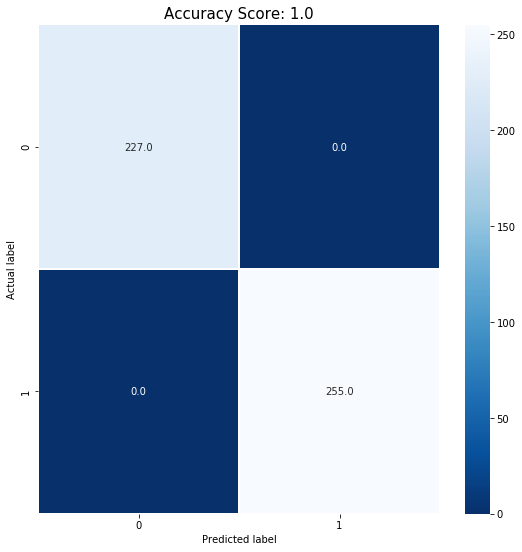

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics


#Confusion matrix
cm = metrics.confusion_matrix(test_labels, logistic_predictions)


plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = False, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(logistic_score)
plt.title(all_sample_title, size = 15);


In [44]:

def plot_image(i , predictions, true_label, img) : 
    prediction, true_label, img = predictions[i], int(true_label[i]), img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = int(prediction)
    if predicted_label == true_label: 
        color = 'blue'
    else : 
        color = 'red'

    plt.xlabel("{} ({})".format(class_names[predicted_label],
                                class_names[int(true_label)]),
                                color=color)

# Plotting Images 

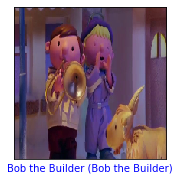

In [22]:
i = 2
plt.figure(figsize = (6,3))
plt.subplot(1,2,1)
plot_image(i , logistic_predictions, Y, X)


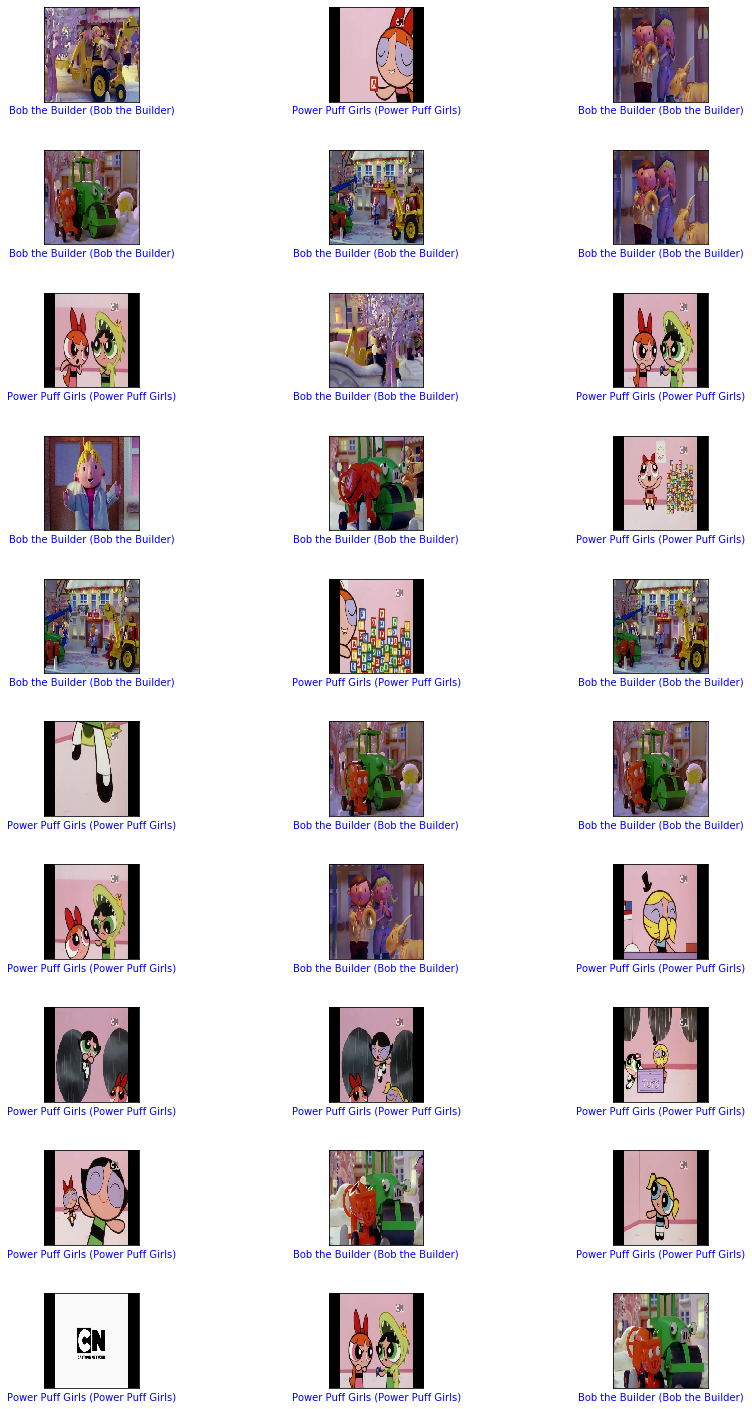

In [23]:
#Now let's plot several images with their predictions 
#Correct predictions are in blue. Incorrect predictions are in red.

num_rows = 10
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images) :
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, logistic_predictions, Y, X)
plt.tight_layout()
plt.show()


## Now it's Your Turn!!

In [46]:
## Import the data and make sure they are in the necessary format here. You can choose your own sets of videos to work with! 

mickey_mouse_video = YouTube('https://www.youtube.com/watch?v=r_ayOJgrrx4')
bugs_bunny_video = YouTube('https://www.youtube.com/watch?v=14KTu4i27j8')


#Look for the valid video format
mouse_stream = mickey_mouse_video.streams.filter(file_extension = "mp4").all()
bunny_stream = bugs_bunny_video.streams.filter(file_extension = "mp4").all()

#Download the videos 
mouse_stream_mp4 = mickey_mouse_video.streams.get_by_itag(18).download()
bunny_stream_mp4 = bugs_bunny_video.streams.get_by_itag(18).download()


##Make sure to modify the class array with your new video names
class_names = ['Bugs Bunny' , 'Mickey Mouse']

## Cut the video into frames. 
You can modify the definition of the cut frames function above to use more or fewer frames. 

In [38]:
##Make sure to modify the directory names to suite your video names 

# create directories
dataset_home = 'Downloads/CartoonsValidation/'
src_directory = 'Downloads/Cartoons/'
makedirs(src_directory, exist_ok = True)

subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['MickeyMouse/', 'BugsBunny/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)
        
        


def cut_Frames(video_name, video_class, dst, n_images, skip_seconds):
    videocap = cv2.VideoCapture(video_name)
    totalNumFrames = int(videocap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(videocap.get(cv2.CAP_PROP_FPS))
    every_xth_frame = math.floor((totalNumFrames - skip_seconds * fps) / n_images) - 1
    
    
    
    success, img = videocap.read()
    framecount = 0
    img_count = 0 
    
    
    while success: 
    
        success, img = videocap.read()
        
        if every_xth_frame == 0 :
            print("pick a different number of total frames or frames to skip")
            break
        
        if(framecount > skip_seconds*30):
            
            if not success:
                break
                
        if (framecount % every_xth_frame == 0):
            cv2.imwrite(dst + video_class + str(img_count) + ".jpg", img)
            img_count += 1
            
            
        if (round(img_count / n_images, 2) * 100 % 10 == 0): 

                    print("Completed:", round(img_count / n_images, 2), "done.", end="\r")



        if img_count == n_images:

            break   

            

        framecount += 1

        
def assignTrainTest(source_directory, dataset_home): 
    # seed random number generator
    seed(1)
    # define ratio of pictures to use for validation
    val_ratio = 0.25
    # copy training dataset images into subdirectories
  
    for file in listdir(source_directory):
        src = source_directory + '/' + file

        dst_dir = 'train/'
        if random() < val_ratio:
            dst_dir = 'test/'
        if file.startswith('MickeyMouse'):
            dst = dataset_home + dst_dir + 'MickeyMouse/'  + file
            copyfile(src, dst)
        elif file.startswith('BugsBunny'):
            dst = dataset_home + dst_dir + 'BugsBunny/'  + file
            copyfile(src, dst)

            
cut_Frames(mouse_stream_mp4, 'MickeyMouse' , src_directory, 1000, 2)
cut_Frames(bunny_stream_mp4 , 'BugsBunny', src_directory, 1000, 2)

assignTrainTest(src_directory, dataset_home)
            

## Make sure to create the image genreator for the train and test set.
You can also choose to rescale the color at this step. Just use color_mode = "grayscale"
Make sure to have one for the test and one for the training set. 



In [39]:
## Add the image generators here

#training directory iterator
train_it = datagen.flow_from_directory(dataset_home + 'train/',
	class_mode='binary', batch_size = 1518 , target_size=(200, 200), shuffle = True)



#testing directory iterator
test_it = datagen.flow_from_directory(dataset_home + 'test/' , 
	class_mode='binary', batch_size= 482, target_size=(200, 200), shuffle =  True)


#Convert to arrays
x, y = train_it.next()
X, Y = test_it.next()



Found 1518 images belonging to 2 classes.
Found 482 images belonging to 2 classes.


## Flatten the pictures 

In [40]:
# Flatten here

train_photos = list()
test_photos = list()



#Train data conversion

for i in range (len(y)):
    
    photo = cv2.cvtColor(x[i], cv2.COLOR_BGR2GRAY)
    #flatten 
    flat = photo.reshape(-1)
    #Add to new list
    train_photos.append(flat)
    
#Test data conversion
    
for i in range(len(Y)):
    photo = cv2.cvtColor(X[i], cv2.COLOR_BGR2GRAY)
    #flatten 
    flat = photo.reshape(-1)
    #Add to new list
    test_photos.append(flat)


    
#Convert lists to arrays 

test_photos = np.asarray(test_photos, dtype=np.float32)
train_photos = np.asarray(train_photos, dtype=np.float32)

train_labels = y

test_labels = Y





## Define and train your logisitc model  

In [41]:
# Define and train your model here and train
from sklearn.linear_model import LogisticRegression


# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()


logisticRegr.fit(train_photos , train_labels)



C:\Users\coder\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## Test your model and generate the Confusion Matrix

In [42]:
# Test model

logistic_predictions = logisticRegr.predict(test_photos)
logistic_score = logisticRegr.score(test_photos, test_labels)
print(logistic_score)




# Generate Confusion Matrix

0.9937759336099585


## Plot images

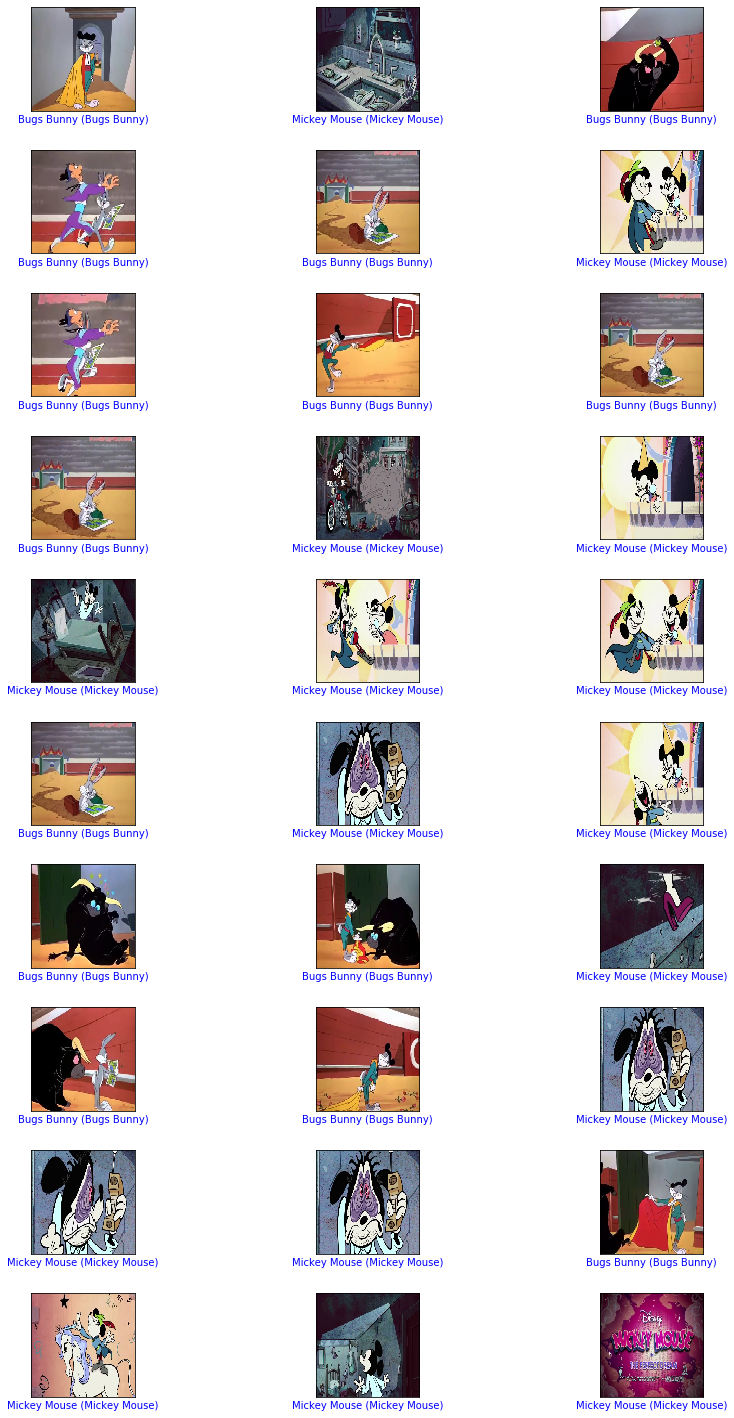

In [47]:
# Use the plot function above to plot some images with their classification
num_rows = 10
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images) :
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, logistic_predictions, Y, X)
plt.tight_layout()
plt.show()

https://towardsdatascience.com/mario-vs-wario-image-classification-in-python-ae8d10ac6d63

# Resources 
